In [31]:
from folktables import ACSDataSource, ACSEmployment
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import os
import math
import pickle
from random import randint

In [32]:
states = ["HI", "CA", "PR", "NV", "NM", "OK", "NY", "WA", "AZ",  "MD",
"TX", "VA", "MA", "GA", "CT", "OR", "IL", "RI", "NC", "CO", "DE", "LA", "UT",
"FL", "MS", "SC", "AR", "SD", "AL", "MI", "KS", "ID", "MN", "TN", "OH", "IN",
"MT", "PA", "NE", "MO", "WY", "ND", "WI", "KY", "NH", "ME", "IA", "VT", "WV"] 

In [33]:
st_ind = 0
state = states[st_ind]
data_src = ACSDataSource(survey_year="2018", horizon="1-Year", survey="person")
acs_data = data_src.get_data(states=[state], download=True)
features, labels, group = ACSEmployment.df_to_numpy(acs_data)
x_train, x_test, y_train, y_test, s_train, s_test = train_test_split(
    features, labels, group, test_size=0.2, random_state=0
)
alpha = [100, 100]

In [34]:
class Teacher:
    def __init__(self, id: int, fair=True):
        self.tchr_id = id
        self.local_s = []
        self.local_m = 0
        self.metrics = {}
        self.status = fair
        self.dataset = self.get_dataset()
        self.splited_data = () # ( x_train, x_test, y_train, y_test, s_train, s_test )
        self.split_dataset()

    def define_model(self, flip=1):
        input_shape = self.splited_data[0].shape[1:]
        if flip==1:
            #tf.keras.utils.set_random_seed(self.tchr_id)
            model = tf.keras.models.Sequential([
                tf.keras.Input(input_shape),
                tf.keras.layers.Dense(16, activation="relu"),
                tf.keras.layers.Dense(32, activation="relu"),
                tf.keras.layers.Dense(64, activation="relu"),
                tf.keras.layers.Dense(128, activation="relu"),
                tf.keras.layers.Dense(64, activation="relu"),
                tf.keras.layers.Dense(32, activation="relu"),
                tf.keras.layers.Dense(16, activation="relu"),
                tf.keras.layers.Dense(1, activation='sigmoid')
            ])
        elif flip == 2:
            model = tf.keras.models.Sequential([
                tf.keras.Input(input_shape),
                tf.keras.layers.Dense(256, activation="relu"),
                tf.keras.layers.Dropout(0.2),
                tf.keras.layers.Dense(1, activation='sigmoid')
            ])
        elif flip == 3:
            model = tf.keras.models.Sequential([
                tf.keras.Input(input_shape),
                tf.keras.layers.Dense(128, activation="relu"),
                tf.keras.layers.Dense(256, activation="relu"),
                tf.keras.layers.Dense(10, activation="relu"),
                tf.keras.layers.Dropout(0.2),
                tf.keras.layers.Dense(1, activation='sigmoid')
            ])
        else:
            model = tf.keras.models.Sequential([
                tf.keras.Input(input_shape),
                tf.keras.layers.Dense(256, activation="relu"),
                tf.keras.layers.Dense(64, activation="relu"),
                tf.keras.layers.Dropout(0.2),
                tf.keras.layers.Dense(1, activation='sigmoid')
            ])

        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=[tf.keras.metrics.BinaryAccuracy(name="accuracy"), tf.keras.metrics.Recall(name="recall")])
        
        return model
    
    def get_dataset(self):
        df = data_src.get_data(states=[states[self.tchr_id]], download=True)
        features, labels, group = ACSEmployment.df_to_numpy(df)
        if not self.status: 
            df = pd.DataFrame(features)
            df.columns = ACSEmployment.features
            df[ACSEmployment.target] = labels

            p_grp_pr = df[(df["RAC1P"] == 1) & (df["ESR"] == True)]
            up_grp_pr = df[(df["RAC1P"] == 2) & (df["ESR"] == True)]
            rest_of_df = df[((df["RAC1P"] != 1) & (df["RAC1P"] != 2)) | (df["ESR"] == False)]
            p_vs_up = pd.concat([p_grp_pr, up_grp_pr])

            #alpha = alphas[states.index(states[self.tchr_id])]
            dist = np.random.dirichlet(alpha, 1)
            size_p_grp = int(dist[0][0]*p_vs_up.shape[0])
            size_up_grp = p_vs_up.shape[0]-size_p_grp

            p_grp = p_grp_pr.sample(size_p_grp, replace=True)
            up_grp = up_grp_pr.sample(size_up_grp, replace=True)
            final_df = pd.concat([p_grp, up_grp, rest_of_df])

            labels = np.array(final_df.pop("ESR"))
            features = final_df.copy()
            group = final_df["RAC1P"]

        return features, labels, group

    def split_dataset(self):
        features, labels, group = self.dataset
        self.splited_data = train_test_split(
            features, labels, group, test_size=0.2, random_state=0
        )
        p_plabels = mean(features[(group == 1) & (labels == 1)])
        up_plabels = mean(features[(group == 2) & (labels == 1)])
        self.local_s = pd.DataFrame(data={"ID": [self.tchr_id], "P_PLBLS": [p_plabels], "UP_PLBLS": [up_plabels]})

    def train_model(self):
        x_train, x_test, y_train, y_test, _, s_test = self.splited_data
        flip = 1
        if self.tchr_id < 12:
            flip = 0
        elif self.tchr_id < 24:
            flip = 2
        elif self.tchr_id < 36:
            flip = 3
        self.model = self.define_model(flip)
        self.model.fit(x_train, y_train, epochs=100, verbose=False)

        self.metrics = fairness(self.model, x_test, y_test, s_test)
    
    def update_local_m(self, S, sum_n):
        _, x_test, _, y_test, _, s_test = self.splited_data
        yhat = np.round(self.model.predict(x_test))
        p_tp = mean(yhat[(s_test == 1) & (y_test==1)])
        up_tp = mean(yhat[(s_test==2) & (y_test==1)])
        p_plabels = S[(S["ID"] == self.tchr_id)]["P_PLBLS"]
        up_plabels = S[(S["ID"] == self.tchr_id)]["UP_PLBLS"]
        others_p_plabels = sum(S[(S["ID"] != self.tchr_id)]["P_PLBLS"])
        others_up_plabels = sum(S[(S["ID"] != self.tchr_id)]["UP_PLBLS"])

        a = p_tp*p_plabels/others_p_plabels
        b = up_tp*up_plabels/others_up_plabels

        self.nk = x_test.shape[0]

        self.local_m = (b-a)*self.nk/sum_n

In [44]:
def mean(myarray):
    mn = np.mean(myarray)
    return 0 if math.isnan(mn) else mn

def fairness(model, x_test, y_test, group_test, true_y_test=[]):
    yhat = np.round(model.predict(x_test))
    ev = model.evaluate(x_test, y_test)
    acc = float(format(ev[1], "0.4f"))
    rec = float(format(ev[2], ".4f"))
    
    p_grp_tpr = mean(yhat[(y_test == 1) & (group_test == 1)])
    up_grp_tpr = mean(yhat[(y_test == 1) & (group_test == 2)])
    
    # equality of difference (opportinuty)
    eod = float(format(abs(p_grp_tpr - up_grp_tpr), ".4f"))

    # statistical parity difference
    p_grp = mean(yhat[(group_test == 1)])
    up_grp = mean(yhat[(group_test == 2)])
    spd = float(format(abs(p_grp - up_grp), ".4f"))

    ev = model.evaluate(x_test, true_y_test)
    acc_tl = float(format(ev[1], "0.4f"))
    rec_tl = float(format(ev[2], ".4f"))
    return {"EOD": eod, "SPD": spd, "ACC": acc, "REC": rec, "ACC_TL": acc_tl, "REC_TL": rec_tl}

In [6]:
states[36]

'MT'

In [37]:
fair = True
tchr_ind = 0
T = Teacher(tchr_ind, fair)
T.train_model()

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step - accuracy: 0.8305 - loss: 0.3813 - recall: 0.8770


In [226]:
path = "../checkpoint/" + states[T.tchr_id] + "/"
if not os.path.exists(path):
    os.makedirs(path)
if T.metrics["EOD"] < 0.1:
    # save the model
    T.model.save(path + "fair_model.keras")
    with open(path+states[T.tchr_id]+"_fair.pkl", "wb") as f:
        pickle.dump(T, f, pickle.HIGHEST_PROTOCOL)
    print(f"Fair model for {states[T.tchr_id]} saved")
else:
    fair = False
    T.model.save(path + "unfair_model.keras")
    with open(path+states[T.tchr_id]+"_unfair.pkl", "wb") as f:
        pickle.dump(T, f, pickle.HIGHEST_PROTOCOL)
    print(f"Unfair model for {states[T.tchr_id]} saved")
print(T.metrics)

Fair model for TN saved
{'EOD': 0.001, 'SPD': 0.0339, 'ACC': 0.8288, 'REC': 0.8651}


In [227]:
alpha = [100,100]
if fair: # a fair model already save
    T = Teacher(tchr_ind, not fair)
    T.train_model()
    if T.metrics["EOD"] > 0.1:
        T.model.save(path + "unfair_model.keras")
        with open(path+states[T.tchr_id]+"_unfair.pkl", "wb") as f:
            pickle.dump(T, f, pickle.HIGHEST_PROTOCOL)
        print(f"Unfair model for {states[T.tchr_id]} saved")
    else:
        print("Not yet :(")
else: # an unfair model already save
    T = Teacher(tchr_ind, fair)
    T.train_model()
    if T.metrics["EOD"] < 0.1:
        T.model.save(path + "fair_model.keras")
        with open(path+states[T.tchr_id]+"_fair.pkl", "wb") as f:
            pickle.dump(T, f, pickle.HIGHEST_PROTOCOL)
        print(f"Fair model for {states[T.tchr_id]} saved")
    else:
        print("Not yet :(")
print(T.metrics)

425/425 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step
425/425 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - accuracy: 0.8480 - loss: 0.3610 - recall: 0.8657
Unfair model for TN saved
{'EOD': 0.2215, 'SPD': 0.4811, 'ACC': 0.8418, 'REC': 0.8608}


In [215]:
# change the unfair model
alpha = [50,100]
T = Teacher(tchr_ind, False)
T.train_model()
if T.metrics["EOD"] > 0.18:
    T.model.save(path + "unfair_model.keras")
    with open(path+states[T.tchr_id]+"_unfair.pkl", "wb") as f:
        pickle.dump(T, f, pickle.HIGHEST_PROTOCOL)
    print(f"Unfair model for {states[T.tchr_id]} saved")
else:
    print("Oups !")
print(T.metrics)

423/423 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step
423/423 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - accuracy: 0.8826 - loss: 0.2840 - recall: 0.9127
Unfair model for IN saved
{'EOD': 0.2475, 'SPD': 0.6433, 'ACC': 0.8805, 'REC': 0.9131}


# fairness distribution

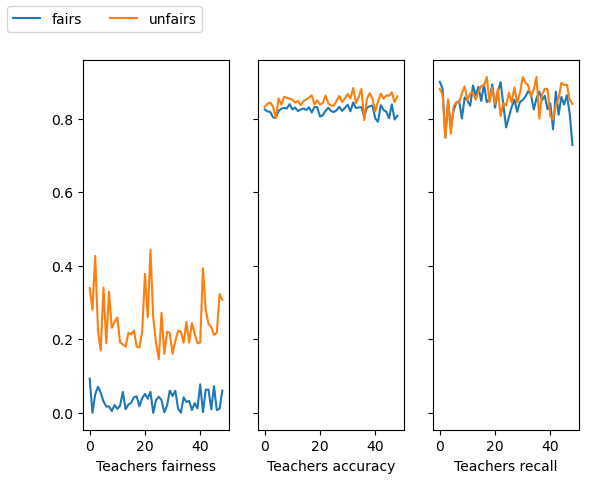

In [12]:
import matplotlib.pyplot as plt
fairs = []
ufairs = []
f_acc, f_rec = [], []
uf_acc, uf_rec = [], []

fig, (ax1, ax2, ax3) = plt.subplots(1, 3,sharey=True)
for st in states:
    with open("../checkpoint/" + st + "/"+ st + "_fair.pkl", "rb") as f:
        tchr = pickle.load(f)
    fairs.append(tchr.metrics["EOD"])
    f_acc.append(tchr.metrics["ACC"])
    f_rec.append(tchr.metrics["REC"])
    with open("../checkpoint/" + st + "/"+ st + "_unfair.pkl", "rb") as f:
        tchr = pickle.load(f)
    ufairs.append(tchr.metrics["EOD"])
    uf_acc.append(tchr.metrics["ACC"])
    uf_rec.append(tchr.metrics["REC"])
ax1.plot(list(range(len(states))), fairs, label="fairs")
ax1.plot(list(range(len(states))), ufairs, label="unfairs")
ax2.plot(list(range(len(states))), f_acc)
ax2.plot(list(range(len(states))), uf_acc)
ax3.plot(list(range(len(states))), f_rec)
ax3.plot(list(range(len(states))), uf_rec)
ax1.set_xlabel("Teachers fairness")
ax2.set_xlabel("Teachers accuracy")
ax3.set_xlabel("Teachers recall")
fig.legend(loc="outside upper left", ncol=3)
plt.show()

# Student stats

In [25]:
from student import *
from aggregator import *
from teacher_ensemble import *

In [15]:
(x_train, x_test, y_train, y_test, s_train, s_test) = load_student_data("AK")

In [77]:
conf = ["All", "Only fair", "Only unfair", "WV0", "Fairfed", "WV1", "WV2"]
def get_agg(cf):
    if cf == "All":
        aggregator = plurality
    elif cf == "Only fair":
        aggregator = only_fair
    elif cf == "Only unfair":
        aggregator = only_unfair
    elif cf == "WV0":
        aggregator = weighed_vote
    elif cf == "Fairfed":
        aggregator = fair_fed_agg
    elif cf == "WV1":
        aggregator = spd_aggregator
    elif cf == "WV2":
        aggregator = methode_2
    
    return aggregator

In [47]:
def training_student(nb_teachers, nb_fair_tchrs):
    rec_acc = {}
    for cf in conf:
        rec_acc[cf] = []

    tchrs_ensemble = Ensemble(nb_teachers, nb_fair_tchrs)
    update_teachers(tchrs_ensemble.tchrs)

    eod = []
    for tchrs in tchrs_ensemble.tchrs:
        eod.append(tchrs.metrics["EOD"])
    set_metrics(eod)

    for cf in conf:
        print(f"methode : {cf}")
        aggregator = get_agg(cf)
        y_train, _ = aggregator(x_train, group=s_train)
        yhat_test, _ = aggregator(x_test, group=s_test)
        st_model = train_student(x_train, y_train, verbose=False)
        st_stats = fairness(st_model, x_test, yhat_test, s_test, y_test)
        rec_acc[cf].append(st_stats["ACC"])
        rec_acc[cf].append(st_stats["REC"])
        rec_acc[cf].append(st_stats["ACC_TL"])
        rec_acc[cf].append(st_stats["REC_TL"])
    return rec_acc

In [48]:
rec_acc = training_student(30, randint(1,30))

methode : All
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/st

360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step 

360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step - accuracy: 0.9734 - loss: 0.0975 - recall: 0.9653
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step - accuracy: 0.8266 - loss: 2.0052 - recall: 0.8487
methode : WV2
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [49]:
rec_acc

{'All': [0.9684, 0.9791, 0.8316, 0.8522],
 'Only fair': [0.9622, 0.9933, 0.8271, 0.8719],
 'Only unfair': [0.951, 0.9159, 0.816, 0.7881],
 'WV0': [0.9663, 0.9815, 0.8295, 0.8601],
 'Fairfed': [0.9632, 0.9828, 0.833, 0.8632],
 'WV1': [0.9688, 0.9581, 0.8292, 0.834],
 'WV2': [0.9684, 0.9941, 0.826, 0.868]}

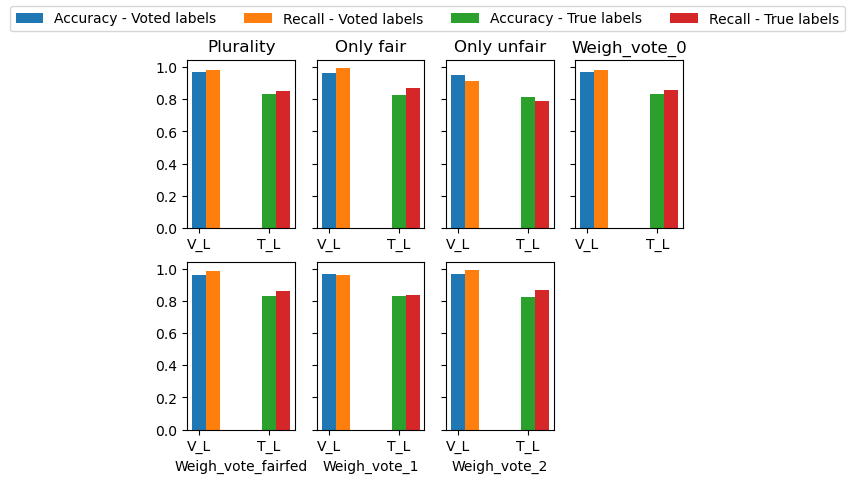

In [98]:
colors = plt.rcParams["axes.prop_cycle"].by_key()['color']

fig, axes = plt.subplots(2, 4, sharey=True)
axes[1][3].set_visible(False)
l = 0
i = 0
b_width = 0.2
x_axes = [1, 2]
for cf in conf:
    ax = axes[l][i]
    if cf == "All":
        lab = "Plurality"
    elif cf == "Only fair":
        lab = "Only fair"
    elif cf == "Only unfair":
        lab = "Only unfair"
    elif cf == "WV0":
        lab = "Weigh_vote_0"
    elif cf == "Fairfed":
        lab = "Weigh_vote_fairfed"
    elif cf == "WV1":
        lab = "Weigh_vote_1"
    elif cf == "WV2":
        lab = "Weigh_vote_2"
    if l < 1:
        ax.set_title(lab)
    else:
        ax.set_xlabel(lab)
    l = 0 if (i<3 and l==0) else 1
    i = (i+1)%4
    acc, rec, acc_tl, rec_tl = rec_acc[cf]
    if cf == "All":
        ax.bar([x_axes[0]], [acc], width = b_width, color = colors[0], label="Accuracy - Voted labels")
        ax.bar([x_axes[0]+b_width], [rec], width = b_width, color = colors[1], label="Recall - Voted labels")
        ax.bar([x_axes[1]], [acc_tl], width = b_width, color = colors[2], label="Accuracy - True labels")
        ax.bar([x_axes[1]+b_width], [rec_tl], width = b_width, color = colors[3], label="Recall - True labels")
    else:
        ax.bar([x_axes[0]], [acc], width = b_width, color = colors[0])
        ax.bar([x_axes[0]+b_width], [rec], width = b_width, color = colors[1])
        ax.bar([x_axes[1]], [acc_tl], width = b_width, color = colors[2])
        ax.bar([x_axes[1]+b_width], [rec_tl], width = b_width, color = colors[3])

    ax.set_xticks([1,2], ["V_L", "T_L"])
fig.legend(loc="outside upper center", ncol=4)
plt.show()